# 4. Artist embedding via node2vec
In this notebook, I find the vector representations of artists using [node2vec](https://snap.stanford.edu/node2vec/), which finds vector representations of nodes in a graph via the following processes:  
   1. Generate (biased) random walks on the graph.   
   2. Apply word2vec on the random walks.   
   
Note that this section shows the training process for a specific set of hyperparameters. See notebooks `5_evaluation_metric.ipynb` and `6_hyperparameter_tuning.ipynb` for details on the hyperparameter selection.

### Contents
1. Preparation for random walk generation
2. Generate random walks
3. Train Word2vec 
4. Examine embeddings  

In [ ]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import networkx as nx
import pickle
plt.style.use("seaborn")

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.callbacks import CallbackAny2Vec
from stellargraph import StellarGraph
from musicians import *

In [2]:
### load data
G = nx.read_gml("graph_80000/graph.gml")
# convert edge's 'album' attribute from list to set
for n1,n2,edge in G.edges(data=True):
    edge['albums'] = set(edge['albums'])

# load ID:name dictionary
with open('graph_80000/ID_name.pkl', 'rb') as f:
    ID_name = pickle.load(f)
with open('graph_80000/name_ID.pkl', 'rb') as f:
    name_ID = pickle.load(f)    
    
# load visited artists
with open('graph_80000/visited_artists.pkl', 'rb') as f:
    visited = pickle.load(f)
visited = set(visited)


# 1 Preparation for random walk generation
* I prepared the graph G for [StellarGraph](https://stellargraph.readthedocs.io/en/stable/), which is used to generate the random walks
* I wrote a function to customize the random walk generation process so that more random walks are sampled for artists with higher degrees. 

## 1(a) Normalize edge weights to [0,1]  
* StellarGraph's Biased Random Walk requires the edge weights to be between 0 and 1. (If edge weights are greater than 1, then the biased random walk only generates a walk of length 1 for q > 1)

In [3]:
# find maximum edge weight
weights = []
for n1, n2, e in G.edges(data = True):
    weights.append(e['weight'])
max_weight = max(weights)

# normalize
for n1, n2, e in G.edges(data = True):
    e['weight'] = e['weight']/max_weight
    
# convert networkx graph to stellargraph 
G_s = StellarGraph.from_networkx(G)

## 1(b) Customize random walk generation

#### Problem
* If we provide an integer `n`, the default StellarGraph random walk generator will sample `n` number of random walks for each node in G.  
* This resulted in a problem in which the embeddings were highly sensitive to nodes with low degree. 
* For example, let's say artists A and B have one collaborative project together. Artist A may be an established artist with 1000 collaborators, while artist B may be a beginning artist with only one collaborator.  Any random walk originating from B will always be of the form [B, A, ...]. If we sample `n` random walks from A and B, then in at least 50% of the sampled random walks, the pair (A,B) will occur as immediate neighbors. As a result, A and B will be embedded extremely close to one another. In fact, artist B will appear as the most similar artist to A, even though artist A may have another collaborator C with more collaborative projects. 

#### Solution
* I wrote a custom function so that the number of random walks sampled from a node is proportional to the degree of the node.

Examine the degrees

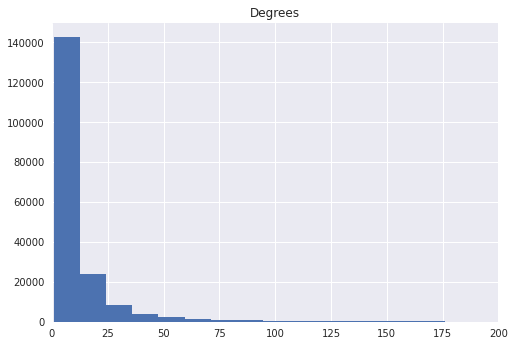

maximum degree:  11679
minimum degree:  1


In [4]:
# visualize the degree
degrees = dict(G.degree()).values()

plt.hist(degrees, bins = 1000)
plt.xlim(0, 200)
plt.title("Degrees")
plt.show()

print('maximum degree: ', max(degrees))
print('minimum degree: ', min(degrees))

In [5]:
# Who are the artists with degree > 1000?
high_degree = []
for (key, item) in dict(G.degree()).items():
    if item > 1000:
        high_degree.append(key)
print("artists with high degree")
print([ID_name[item] for item in high_degree])

artists with high degree
['Robert Schumann', 'Felix Mendelssohn', 'Sergei Prokofiev', 'Claude Debussy', 'Maurice Ravel', 'Igor Stravinsky', 'Johann Sebastian Bach', 'Wolfgang Amadeus Mozart', 'Wiener Philharmoniker', 'Ludwig van Beethoven', 'Franz Joseph Haydn', 'Pyotr Ilyich Tchaikovsky', 'Francis Poulenc', 'Manuel de Falla', 'Franz Liszt', 'Johannes Brahms', 'Carl Maria von Weber', 'Sergei Rachmaninoff', 'Franz Schubert', 'London Philharmonic Orchestra', 'Philharmonia Orchestra', 'Frédéric Chopin', 'Unknown Artist', 'Camille Saint-Saëns', 'Dmitri Shostakovich', 'Alexander Borodin', 'Gabriel Fauré', 'Béla Bartók', 'Bedřich Smetana', 'George Frideric Handel', 'Anonymous', 'Royal Philharmonic Orchestra', 'London Symphony Orchestra', 'Bavarian Radio Symphony Orchestra', 'Munich Radio Orchestra', 'Edvard Grieg', 'Hector Berlioz', 'Charles Gounod', 'Gustav Holst', 'Modest Mussorgsky', 'Gustav Mahler', 'Georges Bizet', 'Jules Massenet', 'Vienna State Opera Orchestra', 'Vienna State Opera Ch

In [6]:
# Who are the artists with degree higher than 5000?
high_degree = []
for (key, item) in dict(G.degree()).items():
    if item > 5000:
        high_degree.append(key)
print("artists with high degree")
print([ID_name[item] for item in high_degree])

artists with high degree
['Johann Sebastian Bach', 'Wolfgang Amadeus Mozart', 'Ludwig van Beethoven', 'Pyotr Ilyich Tchaikovsky', 'Johannes Brahms', 'Franz Schubert', 'George Frideric Handel', 'Anonymous', 'Giuseppe Verdi', 'Traditional']


<b> Group artists according to the following </b>
* 1 <= degree < 5
* 5 <= degree < 25
* 25 <= degree < 50
* 50 <= degree < 100
* 100 <= degree < 200
* 200 <= degree < 500
* 500 <= degree < 1000
* 1000 <= degree < 5000
* 5000 <= degree 

In [7]:
artists_by_degree = {}
cutoffs = [1, 5, 25, 50, 100, 200, 500, 1000, 5000]
for i in cutoffs:
    artists_by_degree[i] = []

for (artist, d) in dict(G.degree()).items():
    if artist in visited:
        # find maximum cutoff value less than d 
        threshold = 1
        for i in cutoffs:
            if d >= i:
                threshold = i
            else:
                break

        artists_by_degree[threshold].append(artist)

<b> Choose the number of random walks to sample for artists in each group. </b>
* `n_walks_by_degree`: (dict)
* `n_walks_by_degree[i] = [j]`: For each artist in `artists_by_degree[i]`, there will be `j` number of random walks sampled with the given artist as the initial node. 
* I decided to use the relation `j = int(i ** 1.2)`

In [8]:
n_walks_by_degree = {}
# specify the number of walks for artists in each degree group
for deg in artists_by_degree.keys():
    n_walks_by_degree[deg] = int(deg**1.2)

The function `sample_random_walks` in `musicians.py` implements the custom random walk generation process. If an artist `A` belongs to group `i` (that is, `A` is in `artists_by_degree[i]`), then sample `n_walks_by_degree[i]` number of random walks from artist `A`.

# 2 Generate random walks

The random walk depends mainly on two parameters: the return parameter `p` and the in-out `q`, which control how quickly the random walk expands out of the starting node. A high value of `p` encourages exploration away from already-visited nodes, while a low value of `p` keeps the walk close to the starting node. A high value of `q` biases the random walk towards close nodes, while a low value of `q` encourages the random walk to explore nodes further away from the starting node. 

* Selected parameters
    * p = 3.8
    * q = 1.7
    * length = 15  
    
Note that these parameters have been selected after hyperparameter tuning. 

In [9]:
# load artists_by_degree dictionary
with open("graph_80000/artist_by_degree.pkl", "rb") as f:
    artists_by_degree = pickle.load(f)
    
# specify number of walks per degree
n_walks_by_degree = {}
for deg in artists_by_degree.keys():
    n_walks_by_degree[deg] = int(deg**1.2)


<font color="red">NOTE</font>: The following cell generates random walks, but it can take a long time. Instead of generating random walks, one can load a pre-generated random walk.


## Load saved random walk

In [10]:
# load generated random walks
file = open("graph_80000/selected_model/random_walk.pkl",'rb')
walks = pickle.load(file)
file.close()

print("Number of random walks: %d" %len(walks))

# This random walk was generated by running the following
"""
# generate random walks 
p = 0.2
q = 4
length = 20
walks = sample_random_walks(G_s, artists_by_degree, n_walks_by_degree, p = p, q = q, length = length)
"""

Number of random walks: 3301785


'\n# generate random walks \np = 0.2\nq = 4\nlength = 20\nwalks = sample_random_walks(G_s, artists_by_degree, n_walks_by_degree, p = p, q = q, length = length)\n'

# 3 Train Word2Vec on sampled random walks
I used [gensim](https://radimrehurek.com/gensim/) to train a Word2Vec model.  
This results in a 300-dimensional vector representation for each artist.

In [11]:
# create custom callbacks for Word2Vec training
class MonitorCallback(CallbackAny2Vec):
    # print training loss after each epoch
    def __init__(self):
        self.epoch = 0
        self.train_loss = []

    def on_epoch_end(self, model):
        # Compute training loss difference from last training
        # Necessary because gensim only returns a cumulative loss, and not the training loss after each epoch
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
            self.train_loss.append(loss)
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
            self.train_loss.append(loss-self.loss_previous_step)
        self.epoch += 1
        self.loss_previous_step = loss
            
class EpochSaver(CallbackAny2Vec):
    # Save model at the end of epoch    
    def __init__(self, path):
        self.path = path
        self.epoch = 0

    def on_epoch_end(self, model):
        output_path = '{}_epoch{}.model'.format(self.path, self.epoch)
        model.save(output_path)
        self.epoch += 1


In [13]:
# parameters
vector_size = 300
window = 5
min_count = 100
sg = 0
epochs = 10

# callbacks
monitor = MonitorCallback()
save_model = EpochSaver('graph_80000/models_training/word2vec')

# train
model = Word2Vec(walks, vector_size = vector_size, window= window, min_count= min_count, sg= sg, 
                 workers=2, epochs = epochs,
                compute_loss = True, callbacks = [monitor, save_model])

Loss after epoch 0: 23348080.0
Loss after epoch 1: 12783072.0
Loss after epoch 2: 9646968.0
Loss after epoch 3: 9363660.0
Loss after epoch 4: 9120652.0
Loss after epoch 5: 5034688.0
Loss after epoch 6: 2994784.0
Loss after epoch 7: 2718160.0
Loss after epoch 8: 2404688.0
Loss after epoch 9: 2061584.0


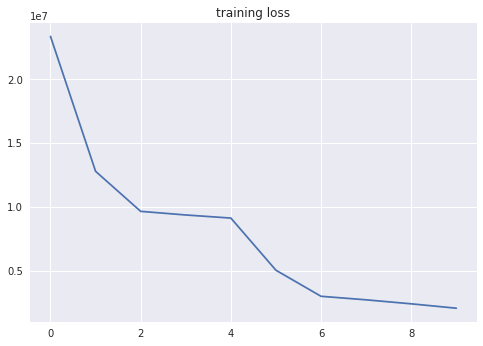

In [14]:
# plot training loss after epoch
plt.plot(monitor.train_loss)
plt.title("training loss")
plt.show()

* Note that it's impossible to create a CV set and monitor the CV loss when training a self-supervised model like word2vec. 
* In order to prevent 'overfitting', I choose the optimal number of epochs to be the point at which training loss stops improving.
* Based on the plot of training loss above, I selected the model after epoch 6. (note that the exact epoch number may vary for each training session)

In [ ]:
# model = Word2Vec.load("graph_80000/models_training/word2vec_epoch6.model")

<b> Save selected model </b>

In [22]:
"""
model_directory = "graph_80000/selected_model"

# save artists degree cutoff and the number of walks generated for each artists in the cutoff group
with open(model_directory + '/num_walks_by_degree.pkl', 'wb') as f:
    pickle.dump(n_walks_by_degree, f)
    
# save parameters used for generating the random walk
random_walk_param = {"p": p,
                    "q": q,
                    "length": length}

with open(model_directory + '/random_walk_parameters.pkl', 'wb') as f:
    pickle.dump(random_walk_param, f)
    
# save parameters used for word2vec training
word2vec_param = {"vector_size": vector_size,
                       "window": window,
                       "min_count": min_count,
                       "sg": sg,
                       "epochs": epochs}
with open(model_directory + '/word2vec_param.pkl', 'wb') as f:
    pickle.dump(word2vec_param, f)
    
# save model 
model.save(model_directory + '/word2vec.model')

# save WordVectors for smaller and faster object
model.wv.save(model_directory + "/word2vec.wordvectors")
"""

# 4 Examine embeddings of example artists
For each example artist, find performers with similar vector representations.

In [7]:
# load selected model
model = Word2Vec.load("graph_80000/selected_model/word2vec.model")

# load name:ID
with open('graph_80000/name_ID.pkl', 'rb') as f:
    name_ID = pickle.load(f)   
    
# load ID:name
with open('graph_80000/ID_name.pkl', 'rb') as f:
    ID_name = pickle.load(f)

In [8]:
# list of artists to examine
test_artists = ['Daniel Barenboim',
                'Emil Gilels', 
                'Mitsuko Uchida', 
                'Mstislav Rostropovich',
                'Daniil Trifonov', 
                'Evgeny Kissin', 
                'Yuja Wang',
                'Herbert von Karajan',
                'Berliner Philharmoniker',
                'Wiener Philharmoniker',
                'Wolfgang Amadeus Mozart',
                'Ludwig van Beethoven',
                'Johannes Brahms'
               ]

test_ID = [name_ID[item] for item in test_artists]

In [9]:
# print most similar artists 
for ID in test_ID:
    print("***** 20 most similar artists to %s *****" %ID_name[ID])
    similar = model.wv.most_similar(ID, topn= 20)
    similar = [ID_name[item[0]] for item in similar]
    print(similar, '\n')

***** 20 most similar artists to Daniel Barenboim *****
['Jacqueline du Pré', 'West-Eastern Divan Orchestra', 'Orchestre de Paris', 'Pinchas Zukerman', 'Gunter von Kannen', 'Waltraud Meier', 'Michael Barenboim', 'Christoph Eschenbach', 'Chicago Symphony Orchestra', 'Staatskapelle Berlin', 'Kian Soltani', 'Gustavo Dudamel', 'Charles Rosen', 'Anja Harteros', 'Arthur Oldham', 'Katherina Kammerloher', 'Vokalensemble Kölner Dom', 'Marc Neikrug', 'Itzhak Perlman', 'René Pape'] 

***** 20 most similar artists to Emil Gilels *****
['Leonid Kogan', 'Daniil Shafran', 'Sviatoslav Richter', 'Kirill Kondrashin', 'USSR State Symphony Orchestra', 'Yakov Zak', 'Yakov Flier', 'David Oistrakh', 'Julius Katchen', 'Emil Giles', 'Van Cliburn', 'Pianozone', 'Heinrich Neuhaus', 'Hisako Kawamura', 'Elena Gilels', 'Anton Ginsburg', 'Maria Yudina', 'Leningrad Philharmonic Orchestra', 'Mstislav Rostropovich', 'Shura Cherkassky'] 

***** 20 most similar artists to Mitsuko Uchida *****
['Benjamin Hochman', 'Radu L